# Assignment 1: Dynamic Time Warping

---

## Task 4) Isolated Word Recognition

Due to the relatively large sample number (e.g. 8kHz), performing [DTW](https://en.wikipedia.org/wiki/Dynamic_time_warping) on the raw audio signal is not advised (feel free to try!).
A better solution is to compute a set of features; here we will extract [mel-frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) over windows of 25ms length, shifted by 10ms.
Recommended implementation is [librosa](https://librosa.org/doc/main/generated/librosa.feature.mfcc.html).

### Data

Download Zohar Jackson's [free spoken digit dataset](https://github.com/Jakobovski/free-spoken-digit-dataset).
There's no need to clone, feel free to use a revision, like [v1.0.10](https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/tags/v1.0.10.tar.gz).
File naming convention is trivial (`{digitLabel}_{speakerName}_{index}.wav`); let's restrict to two speakers, eg. `jackson` and `george`.

### Dynamic Time Warping

[DTW](https://en.wikipedia.org/wiki/Dynamic_time_warping) is closely related to [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) and [Needleman-Wunsch algorithm](https://en.wikipedia.org/wiki/Needleman–Wunsch_algorithm).
The main rationale behind DTW is that the two sequences are can be aligned but their speed and exact realization may very.
In consequence, cost is not dependent on an edit operation but on a difference in observations.

---

### Preparation

In [1]:
import numpy as np
import librosa as lr
from typing import List, Tuple, TypedDict
import os
import pandas as pd

In [2]:
### TODO: Read in files, compute MFCC, and organize
### Notice: You can restrict the number to a few files for each speaker-digit

class Audio(TypedDict):
    digitLabel: int
    speakerName: str
    index: int
    mfccs: List[Tuple[float]]

# audios: List[Audio] = []

speakers = ["george", "jackson", "yweweler"]
audios: dict[str, list[list[Audio]]] = { s: [[] for _ in range(10)] for s in speakers }

### YOUR CODE HERE

audio_folder = "data/free-spoken-digit-dataset-1.0.10/recordings"
max_files_per_digit_per_speaker = 10

file_counts = {speaker: {str(digit): 0 for digit in range(10)} for speaker in speakers}

for filename in os.listdir(audio_folder):
    parts = filename.split('_')
    if len(parts) < 3:
        continue

    digit_label, speaker_name, _ = parts
    if speaker_name not in speakers or file_counts[speaker_name][digit_label] >= max_files_per_digit_per_speaker:
        continue 

    file_path = os.path.join(audio_folder, filename)
    audio, sr = lr.load(file_path)
    mfccs = lr.feature.mfcc(y=audio, sr=sr)
    digit = int(digit_label)
    index = int(parts[2].split('.')[0])

    audio_data = Audio(
        digitLabel=digit,
        speakerName=speaker_name,
        index=index,
        mfccs=mfccs.T.tolist()  # Transposing to have time in rows, then to list
    )

    audios[speaker_name][digit].append(audio_data)
    file_counts[speaker_name][digit_label] += 1

### END YOUR CODE


### Implement Dynamic Time Warping

In [3]:
def dist(x: Tuple[float], y: Tuple[float]) -> float:
    """
    Compute the distance between two samples.

    Arguments:
    x: MFCCs of first sample.
    y: MFCCs of second sample.

    Returns the distance as float
    """
    ### YOUR CODE HERE
    
    return np.linalg.norm(np.array(x) - np.array(y))
    
    ### END YOUR CODE


def dtw(obs1: list, obs2: list, dist_fn) -> float:
    """
    Compute the dynamic time warping score between two observations.
    
    Arguments:
    obs1: List of first observations.
    obs2: List of second observations.
    dist_fn: Similarity function to use.

    Returns the score as float.
    """
    ### YOUR CODE HERE
    
    M, N = len(obs1), len(obs2)
    D = np.full((M + 1, N + 1), np.inf)
    D[0, 0] = 0
    
    for i in range(1, M + 1):
        for j in range(1, N + 1):
            cost = dist_fn(obs1[i-1], obs2[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    
    return D[M, N]

    ### END YOUR CODE

In [4]:
print(dtw(np.array(audios["jackson"][0][0]["mfccs"]), np.array(audios["george"][0][0]["mfccs"]), dist))

3641.634275472263


### Experiment 1: DTW scores

For each speaker and digit, select one recording as an observation (obs1) and the others as tests (obs2). How do scores change across speakers and across digits?

In [6]:
### YOUR CODE HERE

scores = {}
    
# Compute DTW scores
for speaker in audios.keys():
    for digit, data in enumerate(audios[speaker]):
        if speaker not in scores:
            scores[speaker] = {}
        obs1 = np.array(data[0]["mfccs"])  
        scores[speaker][digit] = []
        for i in range(1, len(data)):
            obs2 = np.array(data[i]["mfccs"]) 
            score = dtw(obs1, obs2, dist)
            scores[speaker][digit].append(score)
### END YOUR CODE

In [7]:
data = []
for speaker, digits in scores.items():
    for digit, dtw_scores in digits.items():
        for i, score in enumerate(dtw_scores, start=1):
            data.append({'Speaker': speaker, 'Digit': digit, 'Test #': i, 'DTW Score': score})

df = pd.DataFrame(data)

pivot_df = df.pivot_table(index=['Speaker', 'Digit'], columns='Test #', values='DTW Score')

# Display the pivot table
print(pivot_df)

Test #                    1            2            3            4  \
Speaker  Digit                                                       
george   0      2507.205566  4434.533117  1762.107469  1948.385295   
         1      1155.722280  1355.532757  1628.535864  1016.676615   
         2      2894.173621   882.880428   832.718205   828.368785   
         3       984.944802  1038.854091  1606.250849  1154.993542   
         4       864.804237   764.736420   985.191694   798.930191   
         5       895.097737  1491.168711  1438.430680   933.062941   
         6       902.933285  1090.622019  1449.181426  1862.658140   
         7       919.022318   793.849079   892.469081  2059.865528   
         8       805.204371   871.625883  1232.621949  1081.448403   
         9      1347.986424   868.043170  1088.689969  1491.206413   
jackson  0      2118.397426  1908.059821  1838.366860  1896.170027   
         1      1054.702155  1300.459850  1400.725365  1719.291532   
         2       975

### Implement a DTW-based Isolated Word Recognizer

In [8]:
### TODO: Classify recording into digit label based on reference audio recordings

def recognize(obs: List[Tuple[float]], refs: List[Audio]) -> str:
    """
    Classify the input based on a reference list (train recordings).
    
    Arguments:
    obs: List of input observations (MFCCs).
    refs: List of audio items (train recordings).
    
    Returns classname where distance of observations is minumum.
    """
    ### YOUR CODE HERE
    
    min_distance = float('inf')
    predicted_label = None
    
    for ref in refs:
        ref_mfccs = ref['mfccs']
        digit_label = ref['digitLabel']
        distance = dtw(obs, ref_mfccs, dist)
        
        if distance < min_distance:
            min_distance = distance
            predicted_label = digit_label
            
    return predicted_label
    
    ### END YOUR CODE

### Experiment 2: Speaker-Dependent IWR

Select training recordings from one speaker $S_i$ and disjoint test recordings from the same speaker $S_i$. Compute the Precision, Recall, and F1 metrics, and plot the confusion matrix.

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         7
           1     1.0000    1.0000    1.0000         7
           2     1.0000    1.0000    1.0000         7
           3     1.0000    0.8571    0.9231         7
           4     1.0000    1.0000    1.0000         7
           5     0.7778    1.0000    0.8750         7
           6     1.0000    1.0000    1.0000         7
           7     1.0000    0.8571    0.9231         7
           8     0.8750    1.0000    0.9333         7
           9     1.0000    0.8571    0.9231         7

    accuracy                         0.9571        70
   macro avg     0.9653    0.9571    0.9578        70
weighted avg     0.9653    0.9571    0.9578        70



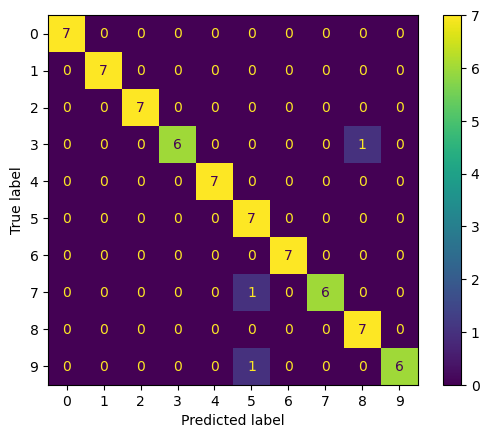

In [9]:
### YOUR CODE HERE

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

speaker = 'george'  
train_set = []  
test_set = [] 

for digit in range(10):
    recordings = audios[speaker][digit]
    train_set.extend(recordings[:3])  
    for rec in recordings[3:]:  
        test_set.append((rec['mfccs'], rec['digitLabel']))

y_true = []
y_pred = []

for obs_mfccs, true_label in test_set:
    predicted_label = recognize(obs_mfccs, train_set)
    y_true.append(true_label)
    y_pred.append(predicted_label)

print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


### END YOUR CODE

### Experiment 3: Speaker-Independent IWR

Select training recordings from one speaker $S_i$ and test recordings from another speaker $S_j$. Compute the Precision, Recall, and F1 metrics, and plot the confusion matrix.

E:\src\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\src\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\src\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.3000    0.3000    0.3000        10
           1     0.4348    1.0000    0.6061        10
           2     0.0556    0.1000    0.0714        10
           3     1.0000    0.1000    0.1818        10
           4     0.3478    0.8000    0.4848        10
           5     0.6667    1.0000    0.8000        10
           6     0.0000    0.0000    0.0000        10
           7     0.0000    0.0000    0.0000        10
           8     0.7143    0.5000    0.5882        10
           9     0.0000    0.0000    0.0000        10

    accuracy                         0.3800       100
   macro avg     0.3519    0.3800    0.3032       100
weighted avg     0.3519    0.3800    0.3032       100

[[ 3  0  0  0  7  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 7  0  1  0  2  0  0  0  0  0]
 [ 0  0  7  1  0  0  0  0  2  0]
 [ 0  2  0  0  8  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  4  3  0  3  0  0]
 [ 0  1  5

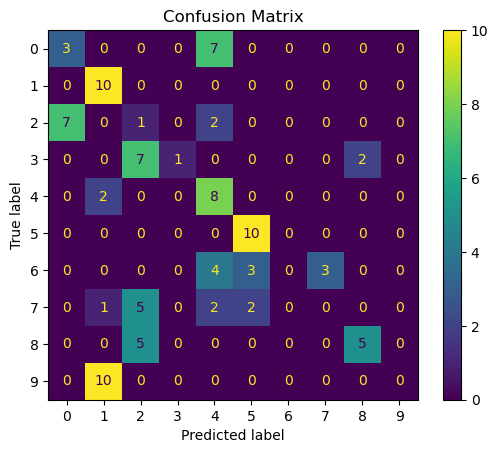

In [16]:
### YOUR CODE HERE

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

speaker_train = 'george'
speaker_test = 'jackson'

train_set = [] 
test_set = []  

for digit in range(10):
    train_set.extend(audios[speaker_train][digit])

for digit in range(10):
    recordings = audios[speaker_test][digit]
    for rec in recordings:
        test_set.append((rec['mfccs'], rec['digitLabel']))

# Predictions and true labels
y_true = []
y_pred = []

for obs_mfccs, true_label in test_set:
    predicted_label = recognize(obs_mfccs, train_set)
    y_true.append(true_label)
    y_pred.append(predicted_label)

print(classification_report(y_true, y_pred, target_names=[str(digit) for digit in range(10)], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=range(10))
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### END YOUR CODE

In [15]:
print("Unique labels in y_true:", np.unique(y_true))
print("Unique labels in y_pred:", np.unique(y_pred))

Unique labels in y_true: [0 1 2 3 4 5 6 7 8 9]
Unique labels in y_pred: [0 1 2 3 4 5 7 8]


### Food for Thought

- What are inherent issues of this approach?
- How does this algorithm scale with a larger vocabulary, how can it be improved?
- How can you extend this idea to continuous speech, ie. ?